In [20]:
# Import required libraries
import os
import numpy as np
import pickle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from PIL import Image


In [35]:


# Paths to datasets
train_path = r"../../archive/skin-disease-datasaet/train_set"
test_path = r"../../archive/skin-disease-datasaet/test_set"

# Check dataset paths
if not os.path.exists(train_path) or not os.path.exists(test_path):
    raise FileNotFoundError("Please check your dataset paths!")

# Step 1: Load and preprocess data
def load_images(folder_path, image_size=(64, 64)):
    images = []
    labels = []
    for disease_name in os.listdir(folder_path):
        disease_folder = os.path.join(folder_path, disease_name)
        if os.path.isdir(disease_folder):
            
            count=0
            for image_name in os.listdir(disease_folder):
                image_path = os.path.join(disease_folder, image_name)
                try:
                    image = Image.open(image_path).resize(image_size).convert('RGB')
                    images.append(np.array(image))
                    labels.append(disease_name)
                    count = count+1
                except Exception as e:
                    print(f"Could not load image {image_name}: {e}")
            print(f"Loading images for: {disease_name} number of images: {count}")
    return np.array(images), np.array(labels)

def preprocess_data(images, labels):
    images = images.astype('float32') / 255.0
    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(labels)
    one_hot_labels = to_categorical(encoded_labels)
    return images, one_hot_labels, label_encoder

# Step 2: Define the CNN model class
class CNNModel:
    def __init__(self, input_shape, num_classes):
        self.model = Sequential([
            Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
            MaxPooling2D((2, 2)),
            Conv2D(64, (3, 3), activation='relu'),
            MaxPooling2D((2, 2)),
            Flatten(),
            Dense(128, activation='relu'),
            Dropout(0.5),
            Dense(num_classes, activation='softmax')
        ])
        self.model.compile(optimizer='adam', 
                           loss='categorical_crossentropy', 
                           metrics=['accuracy'])

    def train(self, X_train, y_train, X_val, y_val, batch_size=32, epochs=10):
        datagen = ImageDataGenerator(rotation_range=10, zoom_range=0.1, horizontal_flip=True)
        datagen.fit(X_train)
        history = self.model.fit(
            datagen.flow(X_train, y_train, batch_size=batch_size),
            validation_data=(X_val, y_val),
            epochs=epochs,
            verbose=1
        )
        return history

    def save(self, model_path, label_encoder_path, label_encoder):
        self.model.save(model_path)
        with open(label_encoder_path, "wb") as f:
            pickle.dump(label_encoder, f)

# Step 3: Train the model
def train():
    # Load training and testing data
    print("Loading training images...")
    train_images, train_labels = load_images(train_path)
    print("Loading test images...")
    test_images, test_labels = load_images(test_path)

    # Preprocess data
    print("Preprocessing data...")
    X_train, y_train, label_encoder = preprocess_data(train_images, train_labels)
    X_test, y_test, _ = preprocess_data(test_images, test_labels)

    # Define model input shape and number of classes
    input_shape = X_train.shape[1:]
    num_classes = y_train.shape[1]

    print("Creating and training the model...")
    model = CNNModel(input_shape, num_classes)
    history = model.train(X_train, y_train, X_test, y_test, epochs=40, batch_size=32)

    # Evaluate the model
    test_loss, test_acc = model.model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Accuracy: {test_acc:.4f}")

    # Save the model and label encoder
    model.save("cnn_model.h5", "label_encoder.pkl", label_encoder)

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title("Loss")

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title("Accuracy")

    plt.show()

# Step 4: Prediction function

def predict(image_path):
    try:
        # Load the trained model
        model = load_model("cnn_model.h5")
        print("Model loaded successfully.")

        # Load the label encoder
        with open("label_encoder.pkl", "rb") as f:
            label_encoder = pickle.load(f)
        print("Label encoder loaded successfully.")

        # Load and preprocess the image
        image = Image.open(image_path).resize((64, 64)).convert('RGB')
        image = np.array(image).astype('float32') / 255.0
        image = np.expand_dims(image, axis=0)  # Add batch dimension
        print(f"Image shape after preprocessing: {image.shape}")

        # Display the image for verification
        plt.imshow(Image.open(image_path))
        plt.title("Input Image")
        plt.axis("off")
        plt.show()

        # Make a prediction
        prediction = model.predict(image)
        print(f"Raw model prediction: {prediction}")

        # Decode the predicted class
        predicted_class = label_encoder.inverse_transform([np.argmax(prediction)])
        return predicted_class[0]

    except Exception as e:
        print(f"An error occurred: {e}")
        return None

Loading training images...
Loading images for: BA- cellulitis number of images: 136
Loading images for: BA-impetigo number of images: 80
Loading images for: FU-athlete-foot number of images: 124
Loading images for: FU-nail-fungus number of images: 129
Loading images for: FU-ringworm number of images: 90
Loading images for: PA-cutaneous-larva-migrans number of images: 100
Loading images for: VI-chickenpox number of images: 136
Loading images for: VI-shingles number of images: 130
Loading test images...
Loading images for: BA- cellulitis number of images: 35
Loading images for: BA-impetigo number of images: 20
Loading images for: FU-athlete-foot number of images: 32
Loading images for: FU-nail-fungus number of images: 33
Loading images for: FU-ringworm number of images: 23
Loading images for: PA-cutaneous-larva-migrans number of images: 25
Loading images for: VI-chickenpox number of images: 34
Loading images for: VI-shingles number of images: 33
Preprocessing data...
Creating and trainin

C:\Users\allur\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\allur\AppData\Roaming\Python\Python310\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - accuracy: 0.1521 - loss: 2.1093 - val_accuracy: 0.3064 - val_loss: 1.9771
Epoch 2/40
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.2476 - loss: 1.9392 - val_accuracy: 0.4085 - val_loss: 1.6930
Epoch 3/40
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.3108 - loss: 1.7551 - val_accuracy: 0.4468 - val_loss: 1.6015
Epoch 4/40
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.4307 - loss: 1.5867 - val_accuracy: 0.5191 - val_loss: 1.4206
Epoch 5/40
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.4746 - loss: 1.4605 - val_accuracy: 0.5574 - val_loss: 1.2983
Epoch 6/40
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.5469 - loss: 1.3222 - val_accuracy: 0.5234 - val_loss: 1.3649
Epoch 7/40
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.5567 - loss: 1.2602 - val_accuracy: 0.5660 - val_loss: 1.2390
Epoch 8/40
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.6276 - loss: 1.1958 - val_accuracy: 0.6426 - val_loss: 1.

Test Accuracy: 0.8043


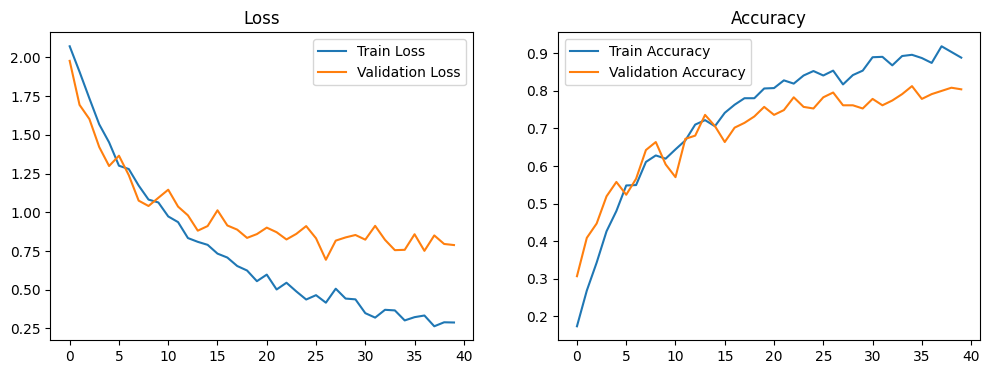

In [36]:
train()

Model loaded successfully.
Label encoder loaded successfully.
Image shape after preprocessing: (1, 64, 64, 3)


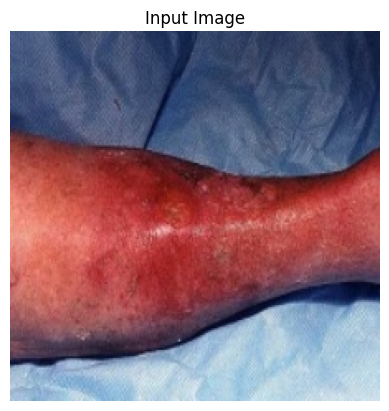

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Raw model prediction: [[9.9957472e-01 7.8663725e-06 5.6966257e-07 1.9707406e-04 5.0870163e-08
  2.1687204e-04 5.3378042e-11 2.8326319e-06]]
The predicted class is: BA- cellulitis


In [32]:
image_path = r"C:\Users\allur\Project\archive\skin-disease-datasaet\train_set\BA- cellulitis\BA- cellulitis (1).jpg"
predicted_class = predict(image_path)
if predicted_class:
    print(f"The predicted class is: {predicted_class}")
else:
    print("Prediction failed. Please check for errors.")


In [1]:
from flask import Flask, request, jsonify, render_template
from flask_cors import CORS
from PIL import Image
from io import BytesIO
import numpy as np


# Initialize Flask app
app = Flask(__name__)
CORS(app)  # Enable Cross-Origin Resource Sharing (CORS)

# Endpoint for predictions
@app.route('/predict', methods=['POST'])
def predict():
    if 'file' not in request.files:
        return jsonify({'error': 'No file uploaded'}), 400

    file = request.files['file']
    if file.filename == '':
        return jsonify({'error': 'No file selected'}), 400

    try:
        # Open the image using PIL
        image = Image.open(BytesIO(file.read()))

        # Resize and preprocess the image to match your model's input requirements
        image = image.resize((64, 64)).convert('RGB')  # Match the input size used in training
        image_array = np.array(image).astype('float32') / 255.0  # Normalize the image
        image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension

        # Call the backend model's predict function directly with the image array
        predicted_class = model.predict_from_array(image_array)

        return jsonify({'prediction': predicted_class}), 200
    except Exception as e:
        return jsonify({'error': str(e)}), 500

@app.route('/index', methods=['GET'])
def webPage():
    return render_template("index.html")

# Run the app
if __name__ == '__main__':
    app.run(debug=True, port=5000)


 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
 * Restarting with watchdog (windowsapi)


SystemExit: 1

C:\Users\allur\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
